In [1]:
import numpy as np
import sympy as smp
from centrex_TlF_hamiltonian import states, hamiltonian
import centrex_TlF_couplings as couplings
import centrex_TlF_lindblad as lindblad
import matplotlib.pyplot as plt
import scipy.constants as cst
from labellines import labelLines
import pickle
import datetime
import pandas as pd
import statsmodels.api as sm

In [2]:
plt.rcParams.update({'font.size': 14})

# Setup

## Papermill Parameters

In [3]:
# this cell is tagged parameters
transition = 'couplings.OpticalTransition(couplings.OpticalTransitionType.R, 1, F1=1.5, F=2)'

polarizations = "[couplings.polarization_Z, couplings.polarization_X]"

powers = np.linspace(1-2e-3,1+2e-3,3)
forward_velocities = np.arange(90, 300+4, 4)
transverse_velocities = np.arange(-4.5, 4.5+0.2, 0.2)

ωp = 0.1*hamiltonian.Γ
ωphase = hamiltonian.Γ
β = 3.8
ωl = 2*np.pi*100e3

dx = 2.54e-2 # dx of laser beam
dy = 2*2.54e-2 # dy of laser beam

initial_state = """states.QuantumSelector(
    J=1, F1=3/2, F=2, mF=2, electronic=states.ElectronicState.X
)"""


nprocs = 7 # number of processes to use

μvy = 0
σvy = 1.5

now = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')

In [4]:
# Parameters
transition = (
    "couplings.OpticalTransition(couplings.OpticalTransitionType.Q, 2, F1=2.5, F=2)"
)
polarizations = "[couplings.polarization_Z, couplings.polarization_X]"
powers = [
    0.1,
    0.2,
    0.30000000000000004,
    0.4,
    0.5,
    0.6,
    0.7000000000000001,
    0.8,
    0.9,
    1.0,
    1.1,
    1.2000000000000002,
    1.3000000000000003,
]
forward_velocities = [
    90,
    94,
    98,
    102,
    106,
    110,
    114,
    118,
    122,
    126,
    130,
    134,
    138,
    142,
    146,
    150,
    154,
    158,
    162,
    166,
    170,
    174,
    178,
    182,
    186,
    190,
    194,
    198,
    202,
    206,
    210,
    214,
    218,
    222,
    226,
    230,
    234,
    238,
    242,
    246,
    250,
    254,
    258,
    262,
    266,
    270,
    274,
    278,
    282,
    286,
    290,
    294,
    298,
    302,
]
transverse_velocities = [
    -4.5,
    -4.3,
    -4.1,
    -3.8999999999999995,
    -3.6999999999999993,
    -3.499999999999999,
    -3.299999999999999,
    -3.0999999999999988,
    -2.8999999999999986,
    -2.6999999999999984,
    -2.4999999999999982,
    -2.299999999999998,
    -2.099999999999998,
    -1.8999999999999977,
    -1.6999999999999975,
    -1.4999999999999973,
    -1.2999999999999972,
    -1.099999999999997,
    -0.8999999999999968,
    -0.6999999999999966,
    -0.49999999999999645,
    -0.29999999999999627,
    -0.09999999999999609,
    0.10000000000000409,
    0.30000000000000426,
    0.5000000000000044,
    0.7000000000000046,
    0.9000000000000048,
    1.100000000000005,
    1.3000000000000052,
    1.5000000000000053,
    1.7000000000000055,
    1.9000000000000057,
    2.100000000000006,
    2.300000000000006,
    2.500000000000006,
    2.7000000000000064,
    2.9000000000000066,
    3.1000000000000068,
    3.300000000000007,
    3.500000000000007,
    3.7000000000000064,
    3.9000000000000075,
    4.1000000000000085,
    4.300000000000008,
    4.500000000000007,
]
ωp = 980176.9079200155
ωphase = 9801769.079200154
ωl = 628318.5307179586
β = 3.8
dx = 0.0254
dy = 0.0508
initial_state = "states.QuantumSelector(\n    J=2, F1=2.5, F=3, mF=2, electronic=states.ElectronicState.X\n)"
nprocs = 7
now = "2022_09_20_12_26"


In [5]:
# use eval to transfer the Transitions, QuantumSelectors and numpy arrays
transition = eval(transition)
polarizations = eval(polarizations)
powers = np.asarray(powers)
forward_velocities = np.asarray(forward_velocities)
transverse_velocities = np.asarray(transverse_velocities)
initial_state = eval(initial_state)

## Functions to convert Power to Rabi and vice-versa

In [6]:
def power_from_rabi_rectangle(Ω: complex, main_coupling: complex, dx: float, dy: float, D: float = 2.6675506e-30) -> float:
    E = Ω*cst.hbar / (main_coupling * D)
    intensity = 1/2 * cst.c * cst.epsilon_0 * E ** 2
    P = intensity * (dx * dy)
    return P.real

def rabi_from_power_rectangle(power: float, main_coupling: complex, dx: float, dy: float, D: float = 2.6675506e-30) -> complex:
    intensity = power / (dx * dy)
    E = np.sqrt(intensity*2 / (cst.c * cst.epsilon_0))
    Ω = E * main_coupling * D / cst.hbar
    return Ω

## Functions to convert transverse velocity to detuning

In [7]:
def doppler_shift(velocity, frequency):
    """calculate the doppler shifted frequency
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
    Returns:
        float: doppler shifted frequency in Hz
    """
    return frequency * (1 + velocity / cst.c)


def velocity_to_detuning(velocity, frequency=1.103e15, Γ=2*np.pi*1.56e6):
    """convert velocity to detuning in units of Γ
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
        Γ (float): Γ [2π⋅Hz]
    Returns:
        float: detuning in units of Γ
    """
    return (doppler_shift(velocity, frequency) - frequency) * 2 * np.pi / Γ

## Function to convert diagonal indices to flattened

In [8]:
def get_diagonal_indices_flattened(size, states = None, mode = 'python'):
    if states is None:
        indices = [i+size*i for i in range(size)]
    else:
        indices = [i+size*i for i in states]
    if mode == 'julia':
        return [i+1 for i in indices]
    elif mode == 'python':
        return indices

## System Parameters

In [9]:
syspars = lindblad.SystemParameters(nprocs = nprocs, Γ=hamiltonian.Γ)

## Vibrational Decay Channels

In [10]:
decay_channels = [
    lindblad.DecayChannel(
        ground = 1*states.CoupledBasisState(None, None, None, None, None, None, v = "other", P=+1),
        excited = transition.qn_select_excited,
        branching = 1e-2,
        description = "vibrational decay"
    )
]

## Odepars

In [11]:
v_to_Γ = velocity_to_detuning(1)*syspars.Γ

odepars = lindblad.odeParameters(
    Ω0 = "Ωl0 * square_wave(t, ωl, 0.) * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δ0      = f"vy*{v_to_Γ}",              # detuning of the laser [rad/s]

    # laser polarization switching
    ωp = ωp,           # polarization switching frequency [rad/s]
    PZ0 = "square_wave(t, ωp, 0.)",
    PX0 = f"square_wave(t, ωp, {np.pi})",
    β = β,
    ωphase = ωphase,
    ωl = ωl,
    
    # molecules
    y0 = 0,                   # molecule start y position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vy = 0,                   # molecule vy [m/s]
)

## Generate the System

In [12]:
transition_selectors = couplings.generate_transition_selectors([transition], [polarizations])

obe_system = lindblad.setup_OBE_system_julia_transitions(
    syspars, odepars, [transition], transition_selectors, verbose=True, full_output=True,
    decay_channels = decay_channels
)

INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations


INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble


INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 7 cores


INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and parameters in Julia


Initialized Julia with 7 processes


## Calculate Rabi rate for 1 W

In [13]:
rabi_1W = rabi_from_power_rectangle(1, np.abs(obe_system.couplings[0].main_coupling), dx, dy)

# Single trajectory run

OpticalTransition(Q(2) F1'=5/2 F'=2) => 11.08 photons


,"|B, J = 2, F₁ = 5/2, F = 2>"
states,
"|X, J = 0>",0.000068
"|X, J = 2>",0.946538
"|X, J = 4>",0.053393


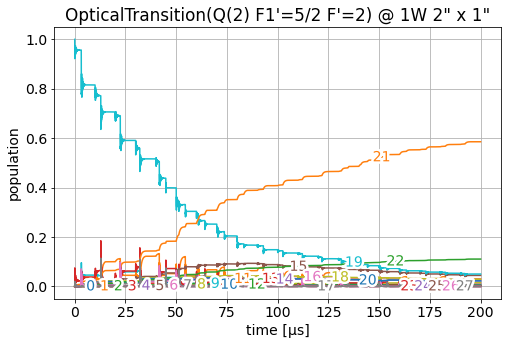

In [14]:
indices_excited = transition.qn_select_excited.get_indices(obe_system.QN)

ρ = states.population.generate_population_states(
    initial_state.get_indices(obe_system.QN), 
    len(obe_system.QN)
)

df = couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground='J')

obe_system.Ωl0 = rabi_1W

result_single = lindblad.do_simulation_single(odepars, (0,200e-6), ρ)

fig, ax = plt.subplots(figsize = (8,5)) 
ax.plot(result_single.t*1e6, result_single.y.T, label = np.arange(len(result_single.y)));
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')

ax.set_title(f'{transition} @ 1W 2" x 1"')

labelLines(ax.get_lines(), zorder = 2.5, align = False, fontsize = 14)

ax.grid(True)

print(f"{transition} => {np.trapz(result_single.y[indices_excited].sum(axis=0), x=result_single.t)*hamiltonian.Γ:.2f} photons")
display(df)

# Scan Power, Detuning and forward velocity

In [15]:
rabi_rates = rabi_from_power_rectangle(powers, np.abs(obe_system.couplings[0].main_coupling), dx, dy)

scan_parameters = ['Ωl0','vy','vz']
scan_values = [rabi_rates, transverse_velocities, forward_velocities]

In [16]:
photon_func = lindblad.setup_state_integral_calculation_state_idxs(
    nphotons = True
)

In [17]:
callback = lindblad.setup_discrete_callback_terminate(
    odepars,
    f"vz*t > {dx}"
)

In [18]:
ensemble_problem = lindblad.setup_problem_parameter_scan(
    odepars,
    ρ = ρ,
    tspan = (0,1_000e-6),
    parameters = scan_parameters,
    values = scan_values,
    dimensions = 2,
    output_func = photon_func,
)

In [19]:
%%time
lindblad.solve_problem_parameter_scan_progress(
    callback = callback,
    ensemble_problem_name=ensemble_problem,
    output_func=photon_func,
    save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), states = indices_excited, mode = 'julia')
)

CPU times: total: 26.5 s
Wall time: 1h 12min 5s


In [20]:
results_power_detuning_velocity_scan = lindblad.get_results_parameter_scan()
X,Y,Z = np.meshgrid(*scan_values)
results_power_detuning_velocity_scan = results_power_detuning_velocity_scan.reshape(Y.T.shape).T

## Save simulation data

In [21]:
transition_name = (
    f"{transition.t.name}{transition.J_ground}_F1_{int(transition.F1*2)}_2_F_{transition.F}"
)

fname = f"{transition_name}_J_init_{initial_state.J}_F1init_{initial_state.F1}_Finit_{initial_state.F}_mFinit_{initial_state.mF}_scan_power_detuning_velocity_with_phase_mod_{now}"

with open(f"{fname}.pkl", 'wb') as f:
    pickle.dump(
        {
            'Ωl': X,
            'power': power_from_rabi_rectangle(X, np.abs(obe_system.couplings[0].main_coupling), dx, dy),
            'vy': Y,
            'vz': Z,
            'photons': results_power_detuning_velocity_scan,
            'main coupling': np.abs(obe_system.couplings[0].main_coupling),
            'odepars': str(odepars),
            'initial state': str(initial_state),
        },
        f
    )

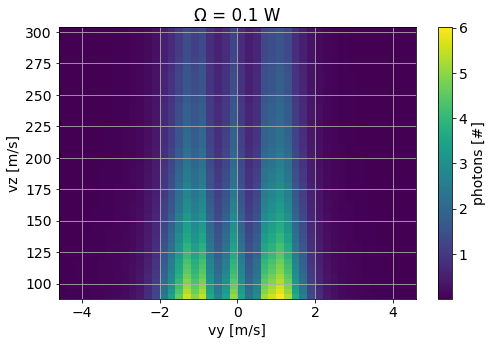

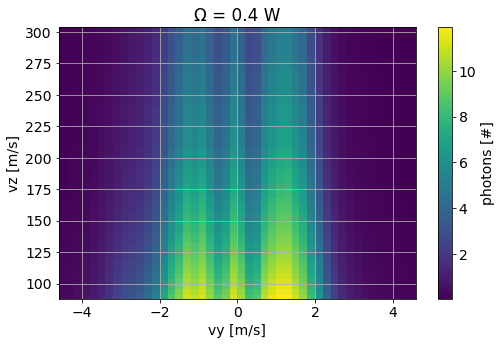

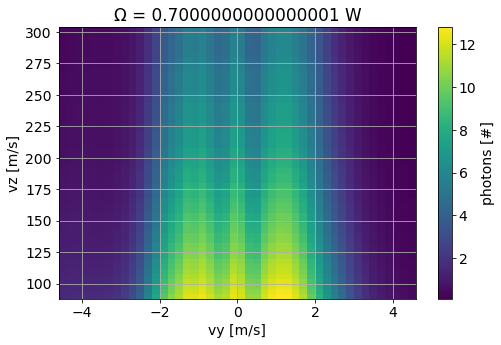

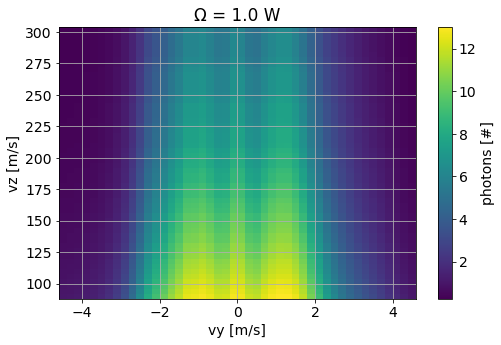

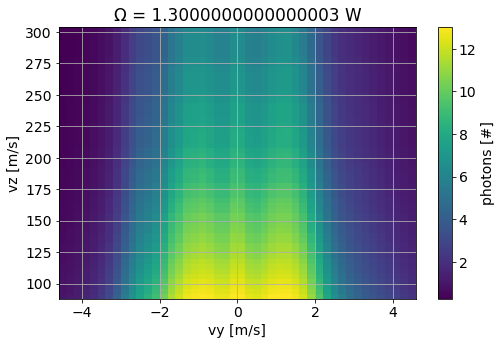

In [22]:
for idΩ in range(len(powers))[::3]:
    fig, ax = plt.subplots(figsize = (8,5))
    cax = ax.pcolormesh(Y[:,idΩ,:],Z[:,idΩ,:],results_power_detuning_velocity_scan[:,idΩ,:])
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("photons [#]")
    ax.set_xlabel("vy [m/s]")
    ax.set_ylabel("vz [m/s]")
    ax.set_title(f"Ω = {powers[idΩ]} W")
    ax.grid(True)

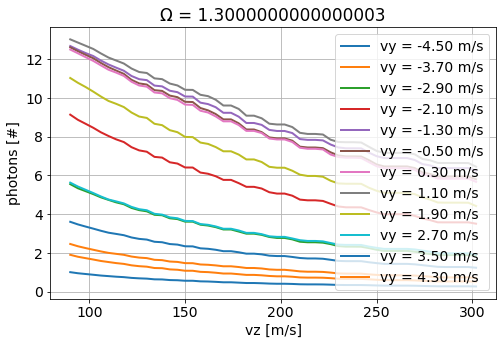

In [23]:
idΩ = -1

fig, ax = plt.subplots(figsize = (8,5))

for idvy, vy in enumerate(transverse_velocities):
    if idvy%4 == 0:
        ax.plot(Z[idvy,idΩ,:], results_power_detuning_velocity_scan[idvy,idΩ,:], lw = 2,
               label = f"vy = {vy:.2f} m/s"
        )
ax.set_xlabel("vz [m/s]")
ax.set_ylabel("photons [#]")
ax.set_title(f"Ω = {powers[idΩ]}")
ax.legend(fontsize=14)
ax.grid(True)

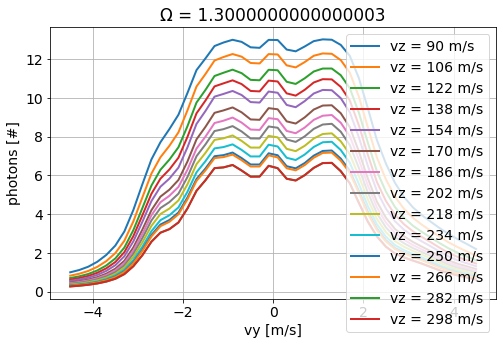

In [24]:
idΩ = -1

fig, ax = plt.subplots(figsize = (8,5))

for idvz, vz in enumerate(forward_velocities):
    if not idvz%4:
        ax.plot(Y[:,idΩ,idvz], results_power_detuning_velocity_scan[:,idΩ,idvz], lw = 2,
               label = f"vz = {vz:.0f} m/s"
        )
ax.set_xlabel("vy [m/s]")
ax.set_ylabel("photons [#]")
ax.set_title(f"Ω = {powers[idΩ]}")
ax.legend(fontsize=14)
ax.grid(True)

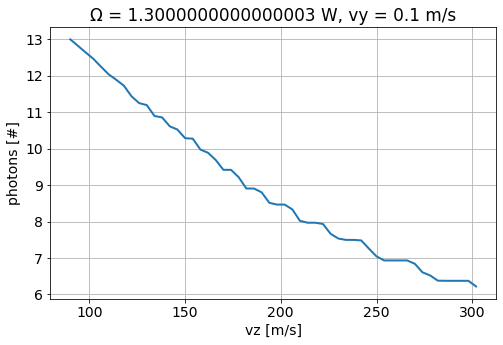

In [25]:
idvy = len(transverse_velocities)//2
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Z[idvy,idΩ,:], results_power_detuning_velocity_scan[idvy,idΩ,:], lw = 2)
ax.set_xlabel("vz [m/s]")
ax.set_ylabel("photons [#]")
ax.set_title(f"Ω = {powers[idΩ]} W, vy = {transverse_velocities[idvy]:.1f} m/s")
ax.grid(True)

## Convolutions

In [26]:
def gaussian(x, μ, σ):
    return np.exp(-(x - μ) ** 2 / (2 * σ ** 2))

In [27]:
def generate_convolutions_transverse(data,powers,forward_velocities,μvy,σvy):
    X,Y = np.meshgrid(powers, forward_velocities)
    conv_transverse = gaussian(
        np.arange(len(transverse_velocities)), 
        (μvy-transverse_velocities.min())/Δvy, 
        σvy/Δvy
    )
    conv_transverse /= conv_transverse.sum()
    
    conv = np.zeros((forward_velocities.size, powers.size))
       
    for idp, power in enumerate(powers):
        conv[:,idp] = data[:,idp,:].T@conv_transverse
    return X,Y,conv

In [28]:
Δvy = round(np.diff(transverse_velocities)[0], 5)
Δvz = np.diff(forward_velocities)[0]

In [29]:
Xp, Yvz, conv = generate_convolutions_transverse(
    results_power_detuning_velocity_scan, 
    powers, 
    np.unique(Z), 
    μvy, 
    σvy
)

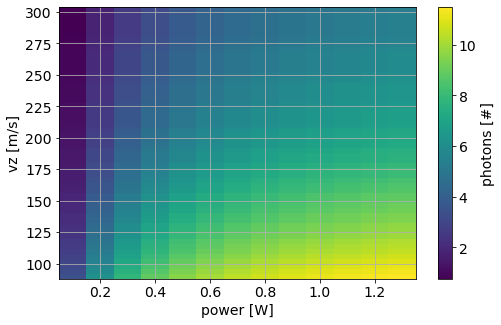

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
cax = ax.pcolormesh(Xp,Yvz,conv)
cbar = fig.colorbar(cax, ax = ax)
cbar.ax.set_ylabel("photons [#]")
ax.set_xlabel("power [W]")
ax.set_ylabel("vz [m/s]")
ax.grid(True)

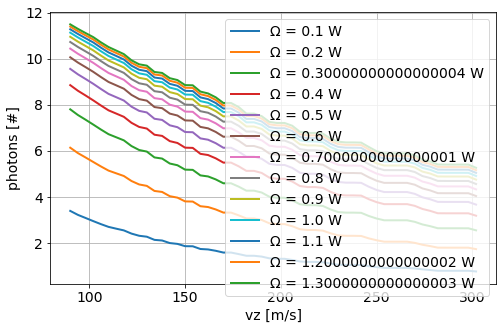

In [31]:
fig, ax = plt.subplots(figsize = (8,5))
for idx, Ωi in enumerate(powers):
    ax.plot(forward_velocities, conv[:,idx], lw = 2, label = f"Ω = {Ωi} W")
    
ax.legend()
ax.set_xlabel("vz [m/s]")
ax.set_ylabel("photons [#]")
ax.grid(True)

## Interpolatation with RectBivariateSpline

In [32]:
from scipy.interpolate import RectBivariateSpline

In [33]:
x = np.unique(Xp.flatten())
y = np.unique(Yvz.flatten())
f_conv = RectBivariateSpline(x,y,conv.T)

## Noise due to gaussian velocity fluctuations

In [34]:
rng = np.random.default_rng()

velocity = 184 # m/s
power = 1 # W

results = []
for _ in range(10):
    velocities = rng.normal(velocity, 16, 1_000_000)        
    velocities.sort()
    
    signal = f_conv(power, velocities).flatten()    
    
    results.append((signal.mean(), np.std(signal)/np.sqrt(len(signal))))

df = pd.DataFrame(
    data = {'mean': [r[0] for r in results], 'stdm': [r[1] for r in results]}
)

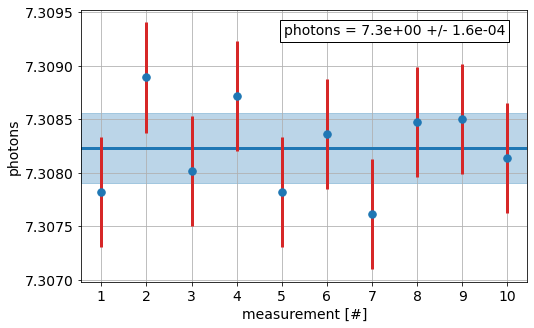

In [35]:
y = df['mean'].values
yerr = df['stdm'].values

nσ = 2

μwa = np.average(y,weights=1/yerr**2)
σwa = np.sqrt(1/np.sum(1/yerr**2))


fig, ax = plt.subplots(figsize=(8,5))

ax.axhline(μwa, lw = 3, color = 'C0');
ax.axhspan(μwa - nσ*σwa, μwa + nσ*σwa, color = 'C0', alpha = 0.3)

ax.errorbar(x=np.arange(len(y))+1, y=y,yerr=yerr, fmt = '.', ms = 15, lw = 3, ecolor = 'C3')

ax.set_xticks(np.arange(len(y))+1)

txt = f"photons = {μwa:.1e} +/- {σwa:.1e}"
ax.text(
    0.95, 0.95, txt, transform=ax.transAxes, ha = 'right', va='top', fontsize = 14,
    bbox=dict(facecolor='white', alpha=1)
)

ax.set_xlabel("measurement [#]")
ax.set_ylabel("photons")
ax.grid(True)

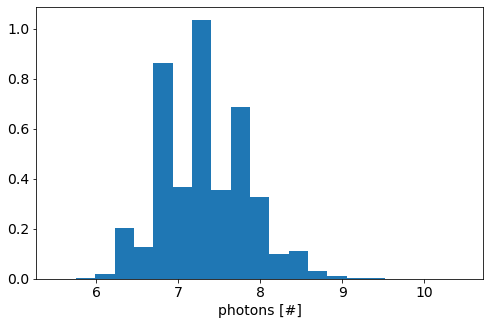

In [36]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(signal, bins = 21, density=True)

ax.set_xlabel("photons [#]");

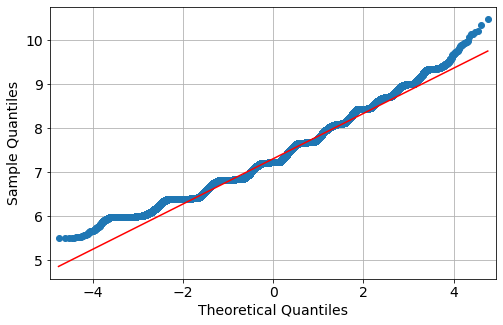

In [37]:
fig,ax=plt.subplots(figsize=(8,5))
sm.qqplot(signal, ax=ax, line='s')
ax.grid(True)

## Noise due to gaussian power fluctuations

In [38]:
rng = np.random.default_rng()

velocity = 184 # m/s
power = 1 # W

results = []
for _ in range(10):
    ps = rng.normal(1, 1e-3, 1_000_000)        
    ps.sort()
    
    signal = f_conv(ps, velocity).flatten()    
    
    results.append((signal.mean(), np.std(signal)/np.sqrt(len(signal))))

df = pd.DataFrame(
    data = {'mean': [r[0] for r in results], 'stdm': [r[1] for r in results]}
)

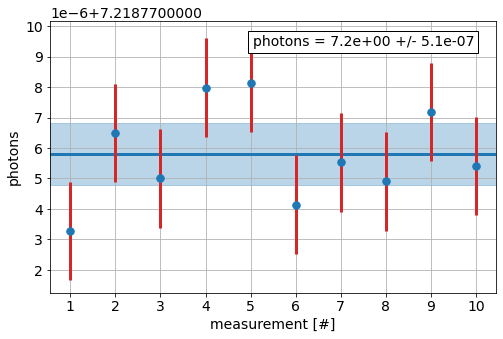

In [39]:
y = df['mean'].values
yerr = df['stdm'].values

nσ = 2

μwa = np.average(y,weights=1/yerr**2)
σwa = np.sqrt(1/np.sum(1/yerr**2))


fig, ax = plt.subplots(figsize=(8,5))

ax.axhline(μwa, lw = 3, color = 'C0');
ax.axhspan(μwa - nσ*σwa, μwa + nσ*σwa, color = 'C0', alpha = 0.3)

ax.errorbar(x=np.arange(len(y))+1, y=y,yerr=yerr, fmt = '.', ms = 15, lw = 3, ecolor = 'C3')

ax.set_xticks(np.arange(len(y))+1)

txt = f"photons = {μwa:.1e} +/- {σwa:.1e}"
ax.text(
    0.95, 0.95, txt, transform=ax.transAxes, ha = 'right', va='top', fontsize = 14,
    bbox=dict(facecolor='white', alpha=1)
)

ax.set_xlabel("measurement [#]")
ax.set_ylabel("photons")
ax.grid(True)

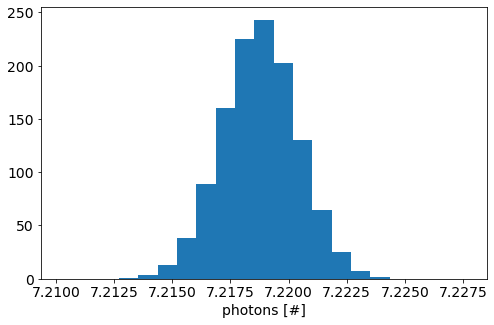

In [40]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(signal, bins = 21, density=True)

ax.set_xlabel("photons [#]");

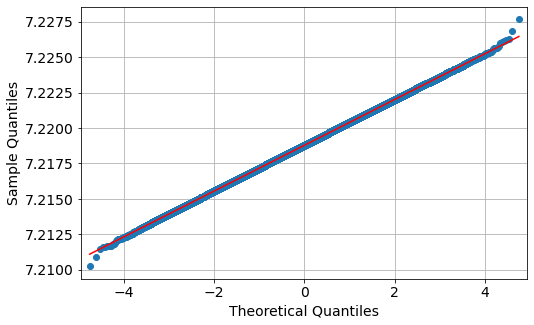

In [41]:
fig,ax=plt.subplots(figsize=(8,5))
sm.qqplot(signal, ax=ax, line='s')
ax.grid(True)